In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
%load_ext tensorboard

# Helper libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime
import pathlib
import os
import sys

print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.3.0


In [ ]:
# set the seed
from numpy.random import seed
seed(1)

In [ ]:
# declare constants
IMG_WIDTH = 300
IMG_HEIGHT = 200
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# load zip file with images for training set
ts_url = 'https://github.com/dphi-official/Datasets/raw/master/animal_data/train_beg.zip'
data_dir = tf.keras.utils.get_file(origin=ts_url, fname='ts', extract=True)
data_dir = pathlib.Path('/root/.keras/datasets/ts'.replace('/ts', '/train_beg'))
print('Data directory: ' + str(data_dir))

image_count = len(list(data_dir.glob('**/*.jpg')))
print('Images loaded: ' + str(image_count))

Data directory: /root/.keras/datasets/train_beg
Images loaded: 1200


In [ ]:
# load zip file with images for testing set
test_set_url = 'https://github.com/dphi-official/Datasets/raw/master/animal_data/test_beg.zip'
test_data_dir = tf.keras.utils.get_file(origin=test_set_url, fname='test', extract=True)
test_data_dir = pathlib.Path('/root/.keras/datasets/test'.replace('/test', '/test_beg'))
print('Data directory for testing set: ' + str(test_data_dir))

# count loaded images
test_image_count = len(list(test_data_dir.glob('**/*.jpg')))
print('Images loaded: ' + str(test_image_count))

# load files to tf dataset
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*.jpg'), shuffle=False)

# reads image
def get_img(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

test_ds = test_list_ds.map(get_img)
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Data directory for testing set: /root/.keras/datasets/test_beg
Images loaded: 400


In [ ]:
# load csv file for training set, read class names
ts = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/animal_data/Training_set_animals.csv")
class_names = np.unique(np.array(ts['animal_type'].values))
print('Class names: ' + str(class_names))

Class names: ['mucca' 'pecora']


In [ ]:
# prepare map containing file names as keys and class names as values
# source: https://stackoverflow.com/a/55995756/2792888
class_names_table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys = tf.constant(ts['filename'].values),
        values = tf.constant(ts['animal_type'].values),
    ),
    default_value = tf.constant('unknown'),
    name = "class_name"
)

In [ ]:
# prepare map for filtering out some bad images
invalid_images_table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys = tf.constant([
          'Image_63.jpg',  # moskito?
          'Image_140.jpg', # kittens
          'Image_183.jpg', # mother and daughter
          'Image_343.jpg', # wedding foto
          'Image_352.jpg', # squirrel
          'Image_502.jpg', # horse
          'Image_538.jpg', # pig
          'Image_569.jpg', # children in class
          'Image_621.jpg', # zebra?
          'Image_778.jpg', # donkey?
          'Image_886.jpg', # alpaca?
          'Image_904.jpg', # car under snow
          'Image_942.jpg', # dog
          'Image_943.jpg'  # village
        ]),
        values = tf.constant([False] * 14),
    ),
    default_value = tf.constant(True),
    name = "invalid_img"
)

def filter_img(f):
  return invalid_images_table.lookup(tf.strings.split(f, os.path.sep)[-1])

In [ ]:
# load files to tensorflow dataset
# source: https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'), shuffle=False)
list_ds = list_ds.filter(filter_img)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

print('\nFirst 5 file names: ')
for f in list_ds.take(5):
  print(f.numpy())


First 5 file names: 
b'/root/.keras/datasets/train_beg/Image_62.jpg'
b'/root/.keras/datasets/train_beg/Image_1095.jpg'
b'/root/.keras/datasets/train_beg/Image_475.jpg'
b'/root/.keras/datasets/train_beg/Image_692.jpg'
b'/root/.keras/datasets/train_beg/Image_867.jpg'


In [ ]:
# prepare train / validation datasets
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
# retrieves classname by filename
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  classname = class_names_table.lookup(parts[-1])
  return 0 if classname == 'mucca' else 1

# decodes image
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

# retrieves (image, label) tuple by file path
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# map tf datasets to list of tuples (image, label)
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (200, 300, 3)
Label:  1


In [ ]:
# add images caching
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
# output sample images
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(20, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy())
  label = label_batch[i]
  label = class_names[label]
  plt.title(label)
  plt.axis("off")

In [ ]:
# use pretrained neural net
# source: https://rubikscode.net/2019/11/11/transfer-learning-with-tensorflow-2/
resnet_base = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

BASE_LEARNING_RATE = 0.0001
EPOCHS = 20

# wrapper class extending keras model
class Wrapper(tf.keras.Model):

    # in constructor we provide layer structure 
    def __init__(self, base_model):
        super(Wrapper, self).__init__()
        self.random_flip = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        self.base_model = base_model
        self.average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(2, activation='softmax')

    # layers are invoked in same order as declared  
    def call(self, inputs):
        x = self.random_flip(inputs)
        x = self.base_model(inputs)
        x = self.average_pooling_layer(x)
        output = self.output_layer(x)
        return output

resnet_base.trainable = False
resnet = Wrapper(resnet_base)

resnet.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=BASE_LEARNING_RATE),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = resnet.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/20
30/30 [==============================] - 563s 19s/step - loss: 0.6818 - accuracy: 0.6332 - val_loss: 0.5725 - val_accuracy: 0.7333
Epoch 2/20
30/30 [==============================] - 556s 19s/step - loss: 0.4649 - accuracy: 0.7854 - val_loss: 0.4257 - val_accuracy: 0.8250
Epoch 3/20
30/30 [==============================] - 556s 19s/step - loss: 0.3427 - accuracy: 0.8753 - val_loss: 0.3336 - val_accuracy: 0.8792
Epoch 4/20
30/30 [==============================] - 556s 19s/step - loss: 0.2665 - accuracy: 0.9070 - val_loss: 0.2839 - val_accuracy: 0.9042
Epoch 5/20
30/30 [==============================] - 557s 19s/step - loss: 0.2179 - accuracy: 0.9345 - val_loss: 0.2279 - val_accuracy: 0.9333
Epoch 6/20
30/30 [==============================] - 556s 19s/step - loss: 0.1844 - accuracy: 0.9514 - val_loss: 0.1973 - val_accuracy: 0.9375
Epoch 7/20
30/30 [==============================] - 556s 19s/step - loss: 0.1629 - accuracy: 0.9493 - val_loss: 0.1797 - val_accuracy: 0.9458
Epoch 

In [ ]:
# output model summary
resnet.summary()

Model: "wrapper_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_5 (RandomFlip)   multiple                  0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 10, 2048)       58331648  
_________________________________________________________________
global_average_pooling2d_5 ( multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  4098      
Total params: 58,335,746
Trainable params: 4,098
Non-trainable params: 58,331,648
_________________________________________________________________


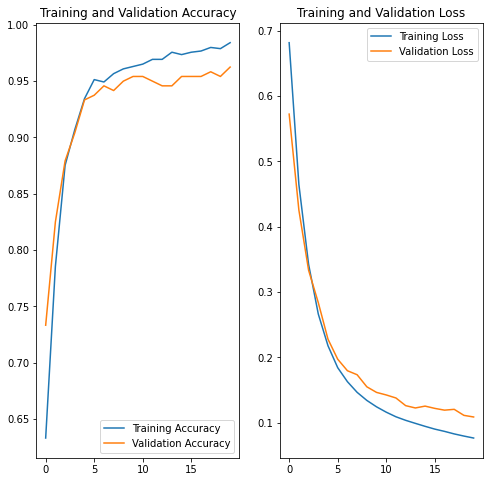

In [ ]:
# output training / validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# predict animal names using trained model
predictions = []

for test_images in test_ds:
  f = lambda p: np.argmax(p)

  prediction_batch = resnet.predict(test_images)
  for prediction in prediction_batch:
      predictions.append(class_names[f(prediction)])

In [ ]:
# output prediction samples
image_batch = next(iter(test_ds))

plt.figure(figsize=(20, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(predictions[i])
  plt.axis("off")

In [ ]:
# reorder predictions array respecting order of images in testing set csv file
paths = list([path.numpy().decode('utf-8') for path in test_list_ds])
res_dict = dict(zip(paths, predictions))
res = []

ts = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/animal_data/Testing_set_animals.csv", header=None)
for name in ts.values:
  res.append(res_dict['/root/.keras/datasets/test_beg/' + name[0]])

print(res)

{'/root/.keras/datasets/test_beg/Image_1.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_10.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_100.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_101.jpg': 'mucca', '/root/.keras/datasets/test_beg/Image_102.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_103.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_104.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_105.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_106.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_107.jpg': 'mucca', '/root/.keras/datasets/test_beg/Image_108.jpg': 'mucca', '/root/.keras/datasets/test_beg/Image_109.jpg': 'mucca', '/root/.keras/datasets/test_beg/Image_11.jpg': 'mucca', '/root/.keras/datasets/test_beg/Image_110.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_111.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_112.jpg': 'pecora', '/root/.keras/datasets/test_beg/Image_113.jpg': 'mucca', '/root/.keras/datasets/